# Deep Learning Model - Categorical Features

The deep learning model based on a Multilayer Perceptron (MLP) architecture utilized categorical metadata (such as subreddit, flair, is_self, and nsfw).

In [ ]:
# Install essential packages 
# !pip install pandas
# !pip install tensorflow
# !pip install scikeras
# !pip install seaborn

In [51]:
# Import essential libraries
import pandas as pd             
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, GlobalAveragePooling1D, Concatenate, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import shap
import sys
import contextlib
import io
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve

In [52]:
# Step 1: Load the dataset
df = pd.read_csv("../data/cleaned_reddit_posts.csv")

Show how many entries fall into each popularity bucket to understand class balance.

In [53]:
print(df["popularity_bucket"].value_counts())

popularity_bucket
high      3415
low       3316
medium    3316
Name: count, dtype: int64


In [54]:
# Step 2: Drop unneeded columns
df = df.drop(columns=["id", "author", "score", "num_comments", "upvote_ratio"])

This step encodes the target column popularity_bucket into integer labels using LabelEncoder.   
The integer labels are then converted into one-hot vectors with to_categorical() for classification.   
The final output y is a one-hot encoded target array used to train the model.   

In [55]:
# Step 3: Encode labels (popularity_bucket) 
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["popularity_bucket"])
y = to_categorical(df["label"])

# Assuming label_encoder is the LabelEncoder used for encoding your labels
print(label_encoder.classes_)


['high' 'low' 'medium']


This code encodes categorical columns like "subreddit" using LabelEncoder after filling missing values.  
It also converts binary and numeric features (like is_self, nsfw, and created_hour) into integer format.   
Finally, all encoded features are combined into a single NumPy array X for model input.  

In [56]:
# Step 4: Encode categorical features
cat_features = ["subreddit", "flair", "media_type"]
encoded_features = []

for col in cat_features:
    le = LabelEncoder()
    df[col] = df[col].fillna("unknown")
    encoded = le.fit_transform(df[col])
    encoded_features.append(encoded)

# Add binary features
encoded_features.append(df["is_self"].astype(int))
encoded_features.append(df["nsfw"].astype(int))
encoded_features.append(df["created_hour"].fillna(0).astype(int))

# Final non-text input
X = np.stack(encoded_features, axis=1) 

This function builds a Multilayer Perceptron (MLP) with three hidden layers and dropout for regularization.   
It uses ReLU activation in hidden layers and softmax for multiclass output.    
The model is compiled with Adam optimizer and categorical crossentropy loss for classification.   

In [89]:
# Step 7: Build the model
def create_model(dropout_rate=0.3):
    model = Sequential()
    model.add(Input(shape=(X.shape[1],)))  
    model.add(Dense(256, activation='relu'))  #128    
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation='relu'))  #64   
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(3, activation='softmax'))
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

The dataset is split into training and testing sets to evaluate model performance.      
A Keras model is wrapped and tuned using GridSearchCV to find the best hyperparameters.    
The best model is then evaluated on the test set, and accuracy is calculated after converting predictions and labels from one-hot to class format.    
We used 3-fold cross-validation to evaluate the model's performance during hyperparameter tuning.  

In [90]:
# Step 8: Compile and train

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Type of X_train:", type(X_train))
print("X_train shape:", X_train.shape)
print("X_train[0] shape:", np.array(X_train[0]).shape)

# Wrap model for GridSearch
model = KerasClassifier(model=create_model, verbose=0)

# Define hyperparameter grid
param_grid = {
    'batch_size': [16, 32],
    'epochs': [15, 20],  #10
    "model__dropout_rate": [0.3, 0.5]
}

# Perform GridSearchCV on training data
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

# Print best hyperparameters
print(f"Best params: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_:.4f}")

# Evaluate on unseen test data
y_pred = grid_result.best_estimator_.predict(X_test)

# Convert predictions to class labels if they are probabilities or one-hot
y_pred_labels = np.argmax(y_pred, axis=1)  

# Convert one-hot y_test to class labels
y_test_labels = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
print(f"Test accuracy: {accuracy:.4f}")

Type of X_train: <class 'numpy.ndarray'>
X_train shape: (8037, 6)
X_train[0] shape: (6,)
Best params: {'batch_size': 16, 'epochs': 20, 'model__dropout_rate': 0.3}
Best accuracy: 0.5583
Test accuracy: 0.5736


Evaluate the model on the test set to get loss and accuracy metrics.

In [93]:
# Evaluate
# Get the underlying Keras model from the best estimator
best_model = grid_result.best_estimator_.model_

# Evaluate on test data using combined features
loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}")

Test loss: 0.9316, Test accuracy: 0.5736


A detailed classification report and confusion matrix to evaluate model performance by comparing true and predicted labels.

In [94]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_labels, y_pred_labels))



Classification Report:
              precision    recall  f1-score   support

        high       0.60      0.70      0.64       650
         low       0.86      0.28      0.42       684
      medium       0.49      0.75      0.60       676

    accuracy                           0.57      2010
   macro avg       0.65      0.58      0.55      2010
weighted avg       0.65      0.57      0.55      2010


Confusion Matrix:
[[452  13 185]
 [152 192 340]
 [148  19 509]]


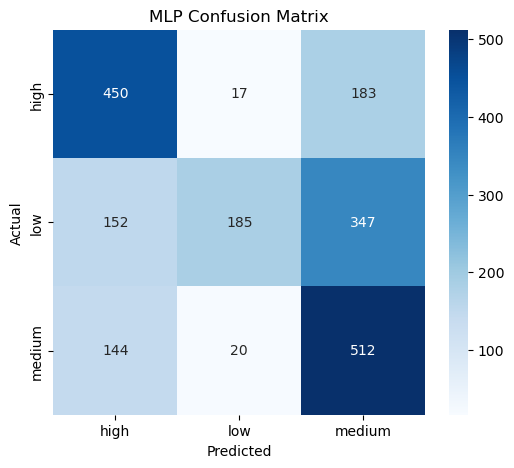

In [68]:
# Plot heatmap
cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('MLP Confusion Matrix')
plt.show()

Calculate and display overall accuracy, precision, recall, and F1 score for model evaluation.

In [84]:
# Evaluate model on test set
y_pred = grid_result.best_estimator_.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Compute metrics
model_accuracy = accuracy_score(y_test_labels, y_pred_labels)
model_precision = precision_score(y_test_labels, y_pred_labels, average='weighted', zero_division=0)
model_recall = recall_score(y_test_labels, y_pred_labels, average='weighted', zero_division=0)
model_f1 = f1_score(y_test_labels, y_pred_labels, average='weighted', zero_division=0)

# Print all metrics
print("\n=== Model Performance Metrics ===")
print(f"Accuracy:  {model_accuracy:.4f}")
print(f"Precision: {model_precision:.4f}")
print(f"Recall:    {model_recall:.4f}")
print(f"F1 Score:  {model_f1:.4f}")



=== Model Performance Metrics ===
Accuracy:  0.5592
Precision: 0.6240
Recall:    0.5592
F1 Score:  0.5400


This code evaluates how well the model's predicted probabilities for class 0 (e.g., "High") match the actual outcomes by plotting a **calibration curve**.    
It compares the predicted probabilities against the true frequencies in binned intervals to check if the model's confidence is accurate.  
The diagonal line represents perfect calibration, so points closer to it indicate better probability estimates.  

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step


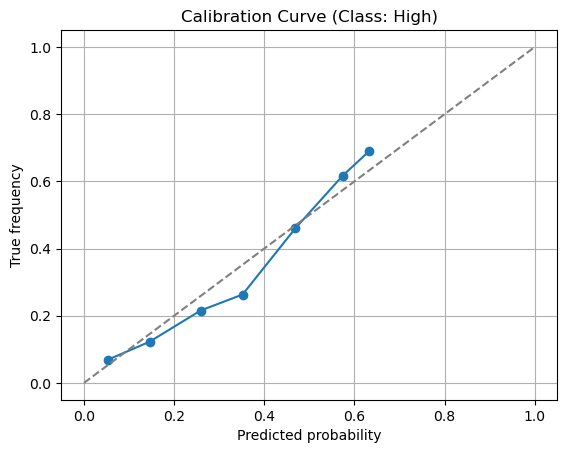

In [91]:
# Get predicted probabilities
y_probs = best_model.predict(X_test)

# For class 0
prob_class0 = y_probs[:, 0]
true_class0 = (y_test_labels == 0).astype(int)

# Calibration curve
prob_true, prob_pred = calibration_curve(true_class0, prob_class0, n_bins=10)

# Plot
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Perfect calibration line
plt.title("Calibration Curve (Class: High)")
plt.xlabel("Predicted probability")
plt.ylabel("True frequency")
plt.grid()
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


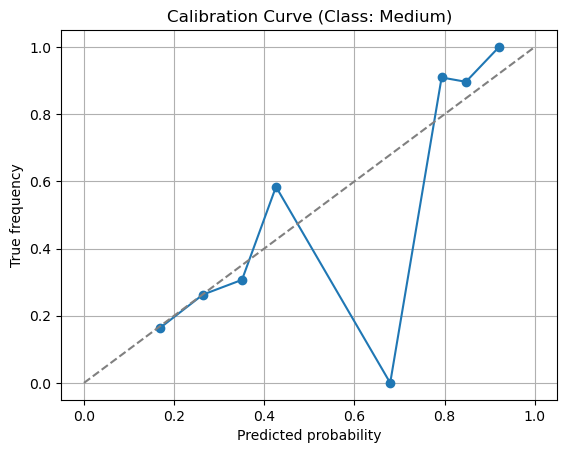

In [95]:
# Get predicted probabilities
y_probs = best_model.predict(X_test)

# For class 1
prob_class0 = y_probs[:, 1]
true_class0 = (y_test_labels == 1).astype(int)

# Calibration curve
prob_true, prob_pred = calibration_curve(true_class0, prob_class0, n_bins=10)

# Plot
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Perfect calibration line
plt.title("Calibration Curve (Class: Medium)")
plt.xlabel("Predicted probability")
plt.ylabel("True frequency")
plt.grid()
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


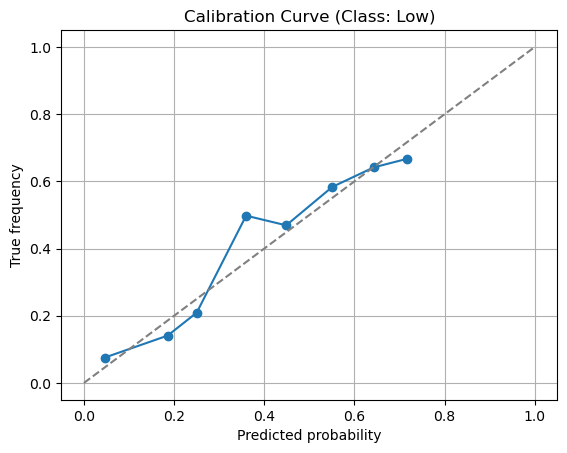

In [87]:
# Get predicted probabilities
y_probs = best_model.predict(X_test)

# For class 2
prob_class0 = y_probs[:, 2]
true_class0 = (y_test_labels == 2).astype(int)

# Calibration curve
prob_true, prob_pred = calibration_curve(true_class0, prob_class0, n_bins=10)

# Plot
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Perfect calibration line
plt.title("Calibration Curve (Class: Low)")
plt.xlabel("Predicted probability")
plt.ylabel("True frequency")
plt.grid()
plt.show()

This code uses SHAP (SHapley Additive exPlanations) to interpret how features influence the model's predictions.    
It creates an explainer object using the trained Keras model and computes SHAP values for a subset of test samples.    
Finally, it visualizes the most important features contributing to predictions using a summary plot.

ExactExplainer explainer: 201it [01:21,  2.14it/s]                         


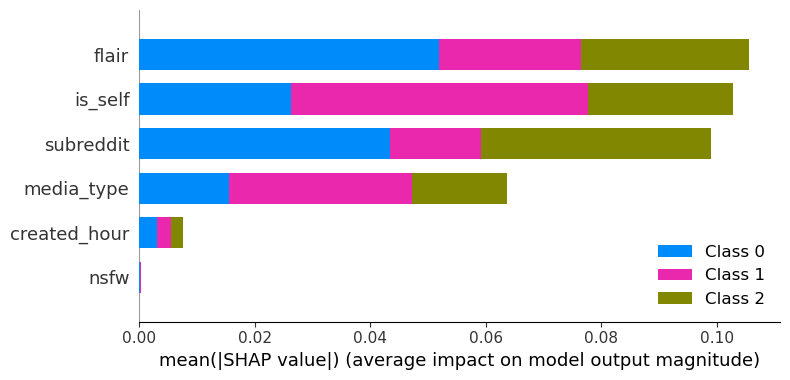

In [74]:
# Wrap Keras model for SHAP
explainer = shap.Explainer(best_model.predict, X_train[:100])  # Keep input small for performance

# Prepare the explainer
explainer = shap.Explainer(best_model.predict, X_train)

# Suppress output
with contextlib.redirect_stdout(io.StringIO()):
    shap_values = explainer(X_test[:200])   # Pick a few samples to explain 

# Plot summary (feature importance)
shap.summary_plot(shap_values, X_test[:50], feature_names=cat_features + ['is_self', 'nsfw', 'created_hour'])


This code creates a naive baseline model that always predicts the most common class from the training set.  
It then evaluates this baseline on the test data using accuracy, precision, recall, and F1 score to provide a reference point.    
The confusion matrix shows how the naive predictions compare with the true labels.  

In [79]:
# Naive Baseline 

# Find the most frequent class in the training set
most_common_class = np.argmax(np.sum(y_train, axis=0))

# Predict that class for all test samples
naive_predictions = np.full(shape=(y_test.shape[0],), fill_value=most_common_class)

# Convert one-hot y_test to class labels
y_test_labels = np.argmax(y_test, axis=1)

# Compute metrics
naive_accuracy = accuracy_score(y_test_labels, naive_predictions)
naive_precision = precision_score(y_test_labels, naive_predictions, average='weighted', zero_division=0)
naive_recall = recall_score(y_test_labels, naive_predictions, average='weighted', zero_division=0)
naive_f1 = f1_score(y_test_labels, naive_predictions, average='weighted', zero_division=0)

print("\n=== Naive Baseline Metrics ===")
print(f"Most Frequent Class: {most_common_class} ({label_encoder.inverse_transform([most_common_class])[0]})")
print(f"Accuracy: {naive_accuracy:.4f}")
print(f"Precision: {naive_precision:.4f}")
print(f"Recall: {naive_recall:.4f}")
print(f"F1 Score: {naive_f1:.4f}")

# Print confusion matrix for naive baseline
print("\nNaive Baseline Confusion Matrix:")
print(confusion_matrix(y_test_labels, naive_predictions))



=== Naive Baseline Metrics ===
Most Frequent Class: 0 (high)
Accuracy: 0.3234
Precision: 0.1046
Recall: 0.3234
F1 Score: 0.1580

Naive Baseline Confusion Matrix:
[[650   0   0]
 [684   0   0]
 [676   0   0]]


In [ ]:
# Compute confusion matrix for naive baseline
cm_naive = confusion_matrix(y_test_labels, naive_predictions)

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm_naive, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Naive Baseline Confusion Matrix')
plt.show()